# LOWESS Non-Parameteric Regression with Bootstrapped Standard Error

(LOWESS: Locally Weighted Scatterplot Smoother)

This notebook reproduces some of the graphics from Chapter 1 of Computer Age Statistical Inference by Efron and Hastie.

In [1]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
# load the data

url = "https://web.stanford.edu/~hastie/CASI_files/DATA/kidney.txt"
df = pd.read_csv(url, header=0, sep=' ')
df.head(4)

,age,tot
0,18,2.44
1,19,3.86
2,19,-1.22
3,20,2.30


In [4]:
n = df.shape[0]

Text(0, 0.5, 'Tot')

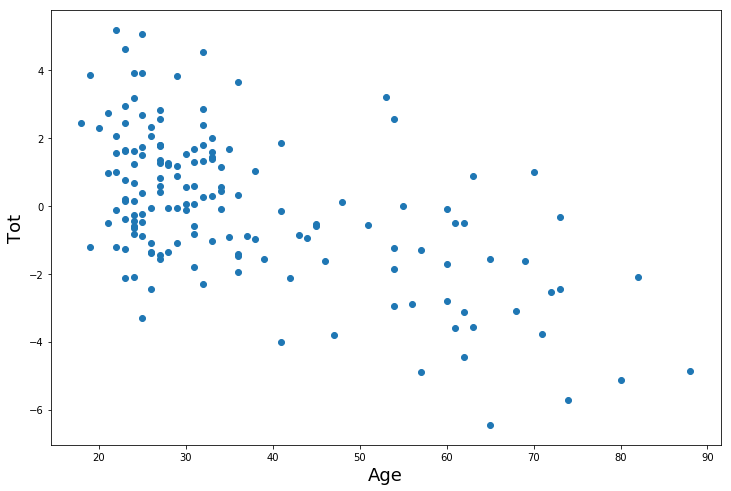

In [5]:
# plot the raw data

fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(df.age, df.tot)
    
ax.set_xlabel('Age', size=18)
ax.set_ylabel('Tot', size=18)

In [6]:
# run basic lowess model and plot the resulting curve

preds = lowess(df.tot, df.age, frac=1/3.)

Text(0, 0.5, 'Tot')

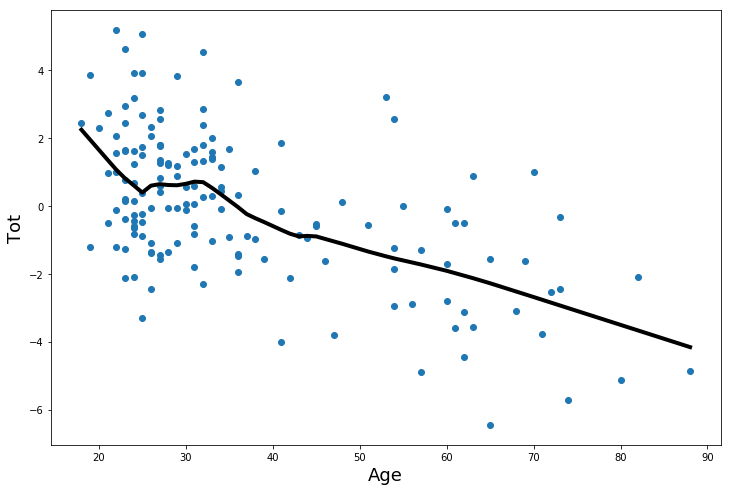

In [7]:
fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(df.age, df.tot)
ax.plot(preds[:, 0], preds[:, 1], c='k', lw=4)  
    
ax.set_xlabel('Age', size=18)
ax.set_ylabel('Tot', size=18)

In [8]:
# create B bootstrapped lowess lines by resampling the data with replacement

it = 0
B = 5000

lboots = []
while it < B:
    indices = np.random.choice(np.array(range(n)), size=n, replace=True)
    dfnew = df.iloc[indices]
    preds = lowess(dfnew.tot, dfnew.age, frac=1/3.)
    
    # nan values are possible depending on the resampling
    if np.isnan(preds).sum() == 0:
        lboots.append(preds)
        it += 1
    else:
        pass
    
lboots[0][:5]

array([[19.        , -0.39328335],
       [21.        ,  0.08654623],
       [21.        ,  0.08654623],
       [22.        ,  0.33389885],
       [22.        ,  0.33389885]])

In [9]:
# interpolate or extrapolate value for all the ages in the "ages" vector and for each of the bootstrapped lines

ages = np.array(list(range(20, 90, 5)))

lboots_preds = np.zeros((len(ages), B))
for i, pred in enumerate(lboots):
    pred = np.unique(pred, axis=0)
    interpolate = interp1d(pred[:, 0], pred[:, 1], fill_value="extrapolate", assume_sorted=True)
    lboots_preds[:, i] = interpolate(ages)
    
ses = np.std(lboots_preds, axis=1, ddof=1)
print(ses)

[0.6830843  0.39709035 0.23919584 0.28707569 0.32426084 0.33255841
 0.32409758 0.34643107 0.37060862 0.4112497  0.47134092 0.56379214
 0.68205273 0.81541987]


Text(0, 0.5, 'Density')

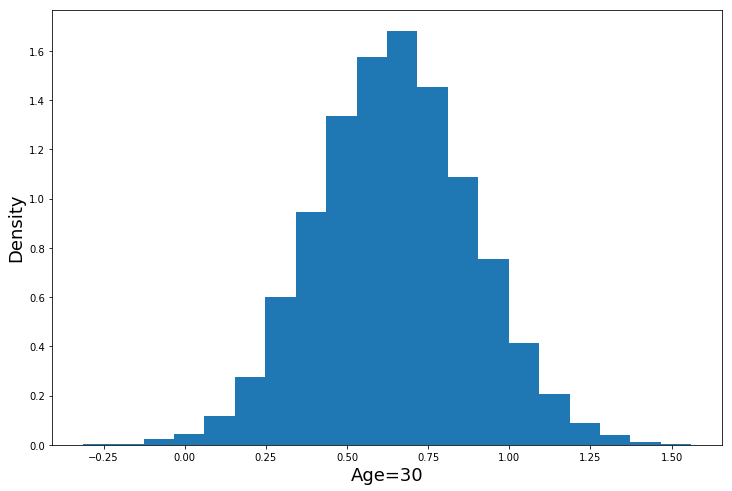

In [10]:
# plot the histogram of predicted values for age 30

fig, ax = plt.subplots(figsize=(12,8))

ax.hist(lboots_preds[2, :], bins=20, density=True)
    
ax.set_xlabel('Age=30', size=18)
ax.set_ylabel('Density', size=18)

In [11]:
# create the +/- 2 * standard error lines

interpolate = interp1d(preds[:, 0], preds[:, 1], fill_value="extrapolate", assume_sorted=True)

bintervals = LineCollection([
    [[age, interpolate(age) - 2 * se], [age, interpolate(age) + 2 * se]] 
    for age, se in zip(ages, ses)
], color='black', linewidths=4, linestyles='dashed')

bintervals

Text(0, 0.5, 'Tot')

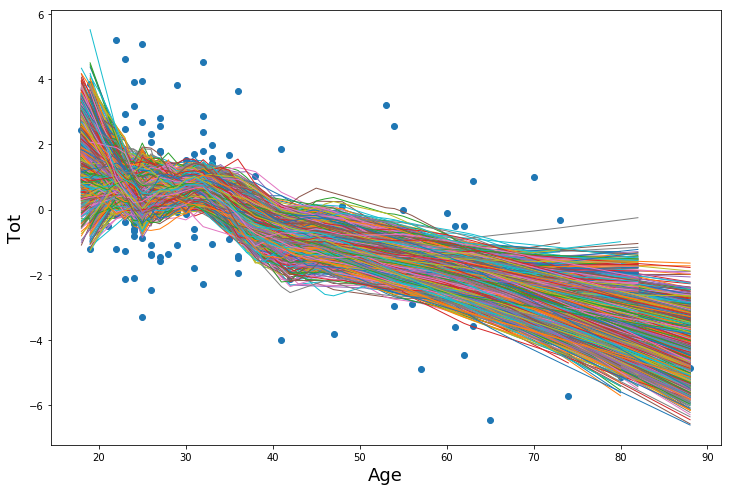

In [12]:
# plot the B bootstrapped lines

fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(df.age, df.tot)

for i in lboots:
    ax.plot(i[:, 0], i[:, 1], lw=1)
    
ax.set_xlabel('Age', size=18)
ax.set_ylabel('Tot', size=18)

Text(0, 0.5, 'Tot')

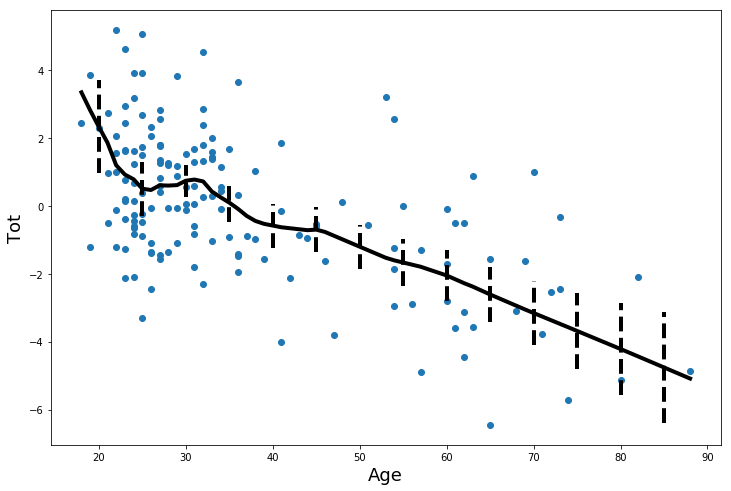

In [13]:
# plot the +/- 2 * standard error lines

fig, ax = plt.subplots(figsize=(12,8))

ax.scatter(df.age, df.tot)
ax.plot(preds[:, 0], preds[:, 1], c='k', lw=4)  
ax.add_collection(bintervals)
    
ax.set_xlabel('Age', size=18)
ax.set_ylabel('Tot', size=18)

In [14]:
# table containing standard error values

tmplt = (
    " {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f}"
    " {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f} {:>5.2f}"
)
print("                                                      age")
print("                --------------------------------------------------------------------------------")
print("                20    25    30    35    40    45    50    55    60    65    70    75    80    85")
print("-" * 96)
print("1. lowess   " + tmplt.format(*interpolate(ages)))
print("2. boostrap\n   std error" + tmplt.format(*ses))

                                                      age
                --------------------------------------------------------------------------------
                20    25    30    35    40    45    50    55    60    65    70    75    80    85
------------------------------------------------------------------------------------------------
1. lowess     2.34  0.51  0.74  0.10 -0.58 -0.70 -1.20 -1.67 -2.05 -2.61 -3.16 -3.68 -4.22 -4.76
2. boostrap
   std error  0.68  0.40  0.24  0.29  0.32  0.33  0.32  0.35  0.37  0.41  0.47  0.56  0.68  0.82
